# Yusuf Arda ILICA - 21243510105

# Imports

In [ ]:
%pip install medmnist

import torch
import medmnist
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from medmnist import PathMNIST, INFO
dataset = PathMNIST(split='train', download=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Hello there, It's", device)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.0 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=

100%|██████████| 206M/206M [00:33<00:00, 6.08MB/s]


Hello there, It's cuda


# Data Loading

In [ ]:
data_flag = 'pathmnist'
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

train_data_transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(10),
    transforms.Normalize(mean=[.5], std=[.5]),
])

val_test_data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5]),
])

train_dataset = DataClass(split='train', download=False, transform=train_data_transform)
val_dataset = DataClass(split='val', download=False, transform=val_test_data_transform)
test_dataset = DataClass(split='test', download=False, transform=val_test_data_transform)

train_size = len(train_dataset)
val_size = len(val_dataset)

batch_size = 512
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Val samples: {len(val_dataset)}")

Train samples: 89996
Test samples: 7180
Val samples: 10004


# Making Sure That I Took Data Correctly

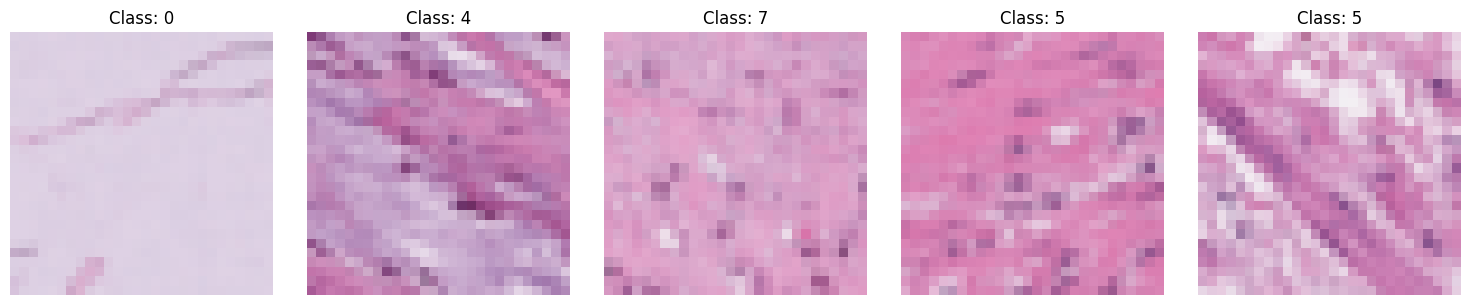

In [ ]:
def show_samples(num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        img, label = train_dataset[i]
        img = img.numpy().transpose(1, 2, 0)
        img = img * 0.5 + 0.5  # Denormalize
        axes[i].imshow(img)
        axes[i].set_title(f"Class: {label.item()}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

show_samples()

# Model Architecture

In [ ]:
class PathMNIST_CNN(nn.Module):
  def __init__(self):
    super(PathMNIST_CNN, self).__init__()
    self.conv1 = nn.Conv2d(3, 128, kernel_size=5, padding= 2)
    self.bn1 = nn.BatchNorm2d(128)
    self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
    self.dropout1 = nn.Dropout(0.1)

    self.conv2 = nn.Conv2d(128, 128, kernel_size=5, padding= 2)
    self.bn2 = nn.BatchNorm2d(128)
    self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
    self.dropout2 = nn.Dropout(0.1)

    #self.conv3 = nn.Conv2d(128, 128, kernel_size=5, padding= 2)
    #self.bn3 = nn.BatchNorm2d(128)
    #self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)
    #self.dropout3 = nn.Dropout(0.1)

    self._to_linear = None
    self._get_conv_output()

    self.fc1 = nn.Linear(self._to_linear, 256)
    self.bn4 = nn.BatchNorm1d(256)
    self.fc2 = nn.Linear(256, 9)


  def _get_conv_output(self):
    with torch.no_grad():
      x = torch.randn(1, 3, 28, 28)
      x = self.pool1(self.dropout1(F.relu(self.bn1(self.conv1(x)))))
      x = self.pool2(self.dropout2(F.relu(self.bn2(self.conv2(x)))))
      #x = self.pool3(self.dropout3(F.relu(self.bn3(self.conv3(x)))))
      self._to_linear = x.view(1, -1).size(1)

  def forward(self, x):
    x = self.pool1(F.relu(self.bn1(self.conv1(x))))
    x = self.dropout1(x)
    x = self.pool2(F.relu(self.bn2(self.conv2(x))))
    x = self.dropout2(x)
    #x = self.pool3(F.relu(self.bn3(self.conv3(x))))
    #x = self.dropout3(x)
    x = x.view(-1, self._to_linear)
    x = F.relu(self.bn4(self.fc1(x)))
    x = self.fc2(x)
    return x

model = PathMNIST_CNN().to(device)
print(model)

PathMNIST_CNN(
  (conv1): Conv2d(3, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.1, inplace=False)
  (conv2): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=4608, out_features=256, bias=True)
  (bn4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=9, bias=True)
)


# Training the Model

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5)

num_epochs = 20

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0
  correct = 0
  total = 0
  for inputs, targets in train_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets.squeeze())
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    _, predicted = outputs.max(1)
    total += targets.size(0)
    correct += predicted.eq(targets).sum().item()

  train_loss = running_loss / len(train_loader)
  train_acc = correct / total
  train_losses.append(train_loss)
  train_accuracies.append(train_acc)

  model.eval()
  val_loss = 0.0
  correct = 0
  total = 0
  with torch.no_grad():
    for inputs, targets in val_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, targets.squeeze())
      val_loss += loss.item()
      _, predicted = outputs.max(1)
      total += targets.size(0)
      correct += predicted.eq(targets).sum().item()

  val_loss = val_loss / len(val_loader)
  scheduler.step(val_loss)
  val_acc = correct / total
  val_losses.append(val_loss)
  val_accuracies.append(val_acc)

  print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Epoch [1/20] Train Loss: 0.6525, Train Acc: 59.0898 | Val Loss: 0.6605, Val Acc: 56.2746
Epoch [2/20] Train Loss: 0.3638, Train Acc: 58.9911 | Val Loss: 0.4553, Val Acc: 57.9349
Epoch [3/20] Train Loss: 0.2796, Train Acc: 58.9422 | Val Loss: 0.3701, Val Acc: 58.8022
Epoch [4/20] Train Loss: 0.2291, Train Acc: 58.9925 | Val Loss: 0.3074, Val Acc: 58.9874
Epoch [5/20] Train Loss: 0.1927, Train Acc: 59.0279 | Val Loss: 0.2415, Val Acc: 58.1012
Epoch [6/20] Train Loss: 0.1642, Train Acc: 58.9827 | Val Loss: 0.3178, Val Acc: 59.8234
Epoch [7/20] Train Loss: 0.1380, Train Acc: 59.0852 | Val Loss: 0.2091, Val Acc: 58.0957
Epoch [8/20] Train Loss: 0.1226, Train Acc: 59.0449 | Val Loss: 0.3894, Val Acc: 59.4460
Epoch [9/20] Train Loss: 0.1113, Train Acc: 59.1031 | Val Loss: 0.2021, Val Acc: 58.6413
Epoch [10/20] Train Loss: 0.0984, Train Acc: 59.1001 | Val Loss: 0.3021, Val Acc: 57.6578
Epoch [11/20] Train Loss: 0.0920, Train Acc: 59.1375 | Val Loss: 0.2523, Val Acc: 57.9867
Epoch [12/20] Train

# Evaluation

In [ ]:
model.eval()
test_loss = 0.0
correct = 0
total = 0
all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets.squeeze())
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

test_loss = test_loss / len(test_loader)
test_acc = correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.8219, Test Accuracy: 67.5916


# Visualization

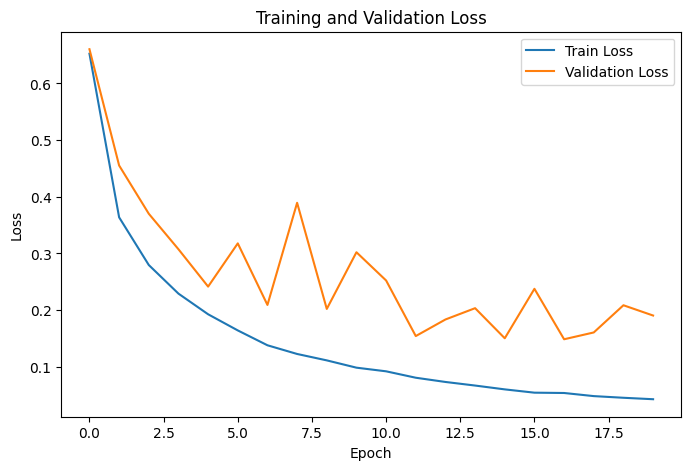

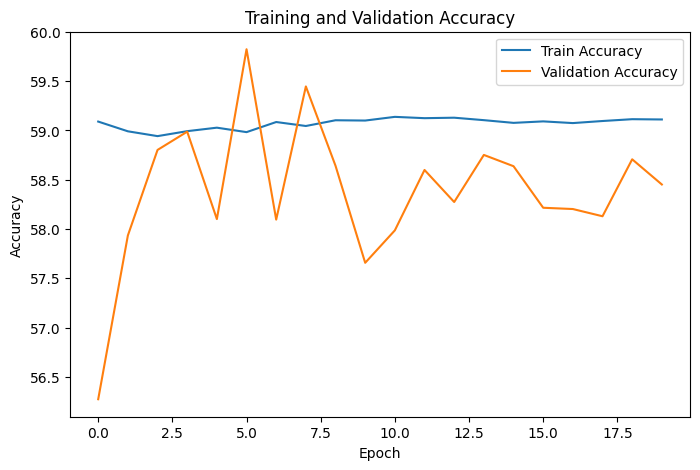

In [ ]:
# Loss Curves
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Accuracy Curves
plt.figure(figsize=(8, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

#Confusion Matrix & Classification Report

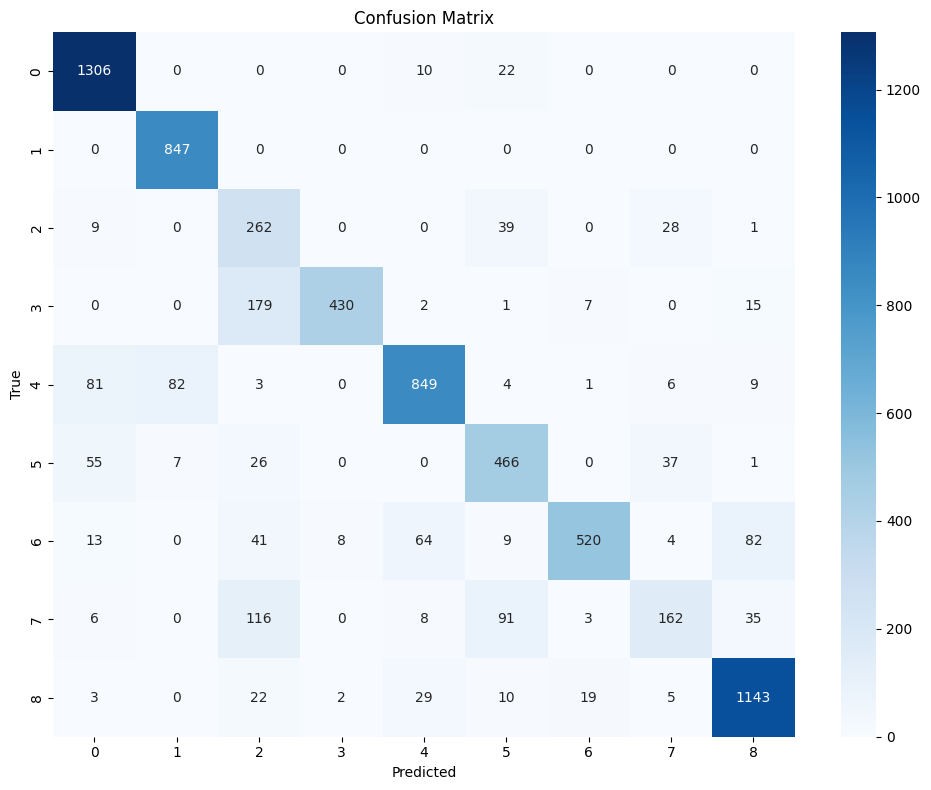

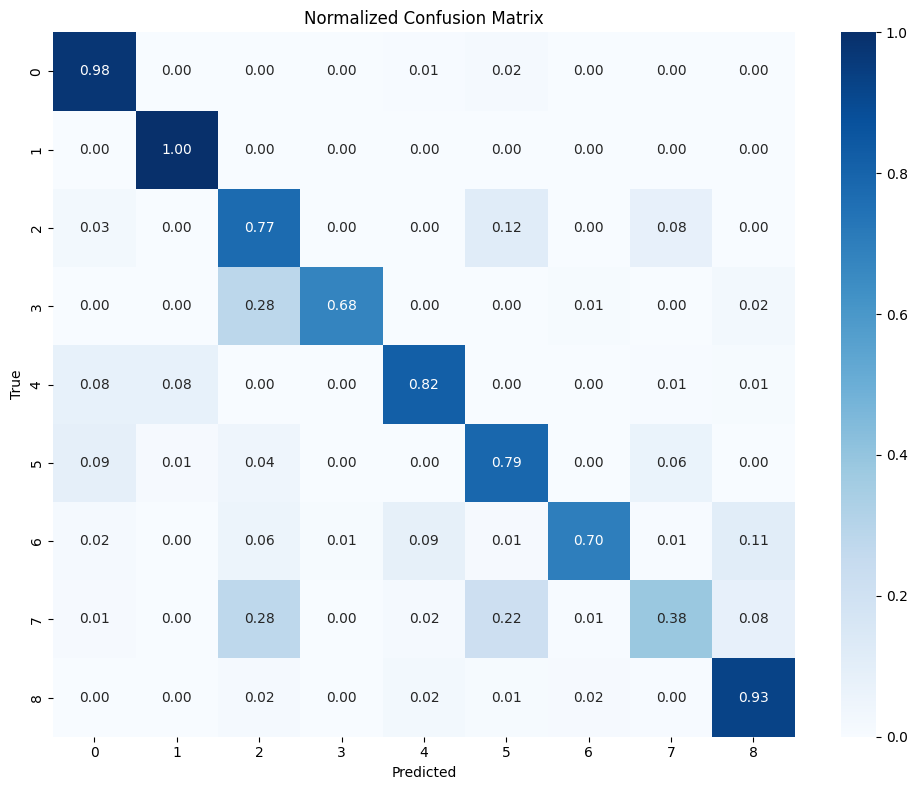

Classification Report:
              precision    recall  f1-score   support

     Class 0     0.8866    0.9761    0.9292      1338
     Class 1     0.9049    1.0000    0.9501       847
     Class 2     0.4037    0.7729    0.5304       339
     Class 3     0.9773    0.6782    0.8007       634
     Class 4     0.8825    0.8203    0.8503      1035
     Class 5     0.7259    0.7872    0.7553       592
     Class 6     0.9455    0.7018    0.8056       741
     Class 7     0.6694    0.3848    0.4887       421
     Class 8     0.8888    0.9270    0.9075      1233

    accuracy                         0.8336      7180
   macro avg     0.8094    0.7831    0.7797      7180
weighted avg     0.8539    0.8336    0.8335      7180



NameError: name 'precision_score' is not defined

In [ ]:
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(9), yticklabels=range(9))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# Normalized Confusion Matrix
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=range(9), yticklabels=range(9))
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

print("Classification Report:")
class_names = [f"Class {i}" for i in range(9)]
print(classification_report(all_targets, all_preds, target_names=class_names, digits=4))

# Additional metrics per class
precision = precision_score(all_targets, all_preds, average=None)
recall = recall_score(all_targets, all_preds, average=None)
f1 = f1_score(all_targets, all_preds, average=None)

# Create DataFrame for better visualization
import pandas as pd
metrics_df = pd.DataFrame({
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1
}, index=class_names)

# Plot metrics per class
plt.figure(figsize=(12, 6))
metrics_df.plot(kind='bar', ax=plt.gca())
plt.title('Classification Metrics per Class')
plt.ylabel('Score')
plt.xlabel('Class')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#Graphing Experiments

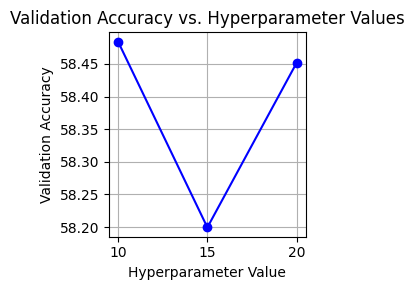

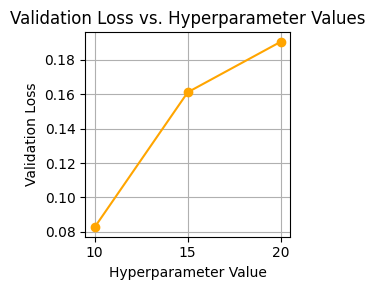

In [ ]:
hyperparameter_values = [10, 15, 20]
val_accuracies = [58.4841, 58.1994, 58.4518]
val_losses = [0.0826, 0.1611, 0.1905]

# Plot Validation Accuracy
plt.figure(figsize=(3, 3))
plt.plot(hyperparameter_values, val_accuracies, marker='o', linestyle='-', color='blue')
plt.title('Validation Accuracy vs. Hyperparameter Values')
plt.xlabel('Hyperparameter Value')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Validation Loss
plt.figure(figsize=(3, 3))
plt.plot(hyperparameter_values, val_losses, marker='o', linestyle='-', color='orange')
plt.title('Validation Loss vs. Hyperparameter Values')
plt.xlabel('Hyperparameter Value')
plt.ylabel('Validation Loss')
plt.grid(True)
plt.tight_layout()
plt.show()